In [ ]:
import os
import numpy as np
import GPyOpt
import tensorflow.keras as K

from keras.applications.densenet import DenseNet121
from keras.datasets import cifar10
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
num_classes = 10
input_shape = X_train.shape[1:]

# Normalize pixel values
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Define the DenseNet-121 model
def create_model(learning_rate, beta1, beta2, num_epochs, batch_size):
    base_model = DenseNet121(include_top=False,
                             weights='imagenet',
                             input_shape=input_shape)

    model = base_model.output
    model = K.layers.GlobalAveragePooling2D()(model)
    model = K.layers.Dropout(0.5)(model)
    model = K.layers.Dense(num_classes, activation='softmax')(model)

    model = K.Model(inputs=base_model.input, outputs=model)

    optimizer = Adam(lr=learning_rate, beta_1=beta1, beta_2=beta2)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model

# Define the evaluation function
def evaluate_model(params):
    learning_rate = params[0, 0]
    beta1 = params[0, 1]
    beta2 = params[0, 2]
    num_epochs = int(params[0, 3])
    batch_size = int(params[0, 4])

    model = create_model(learning_rate, beta1, beta2, num_epochs, batch_size)

    # Define checkpoint and early stopping callbacks
    ckpt_path = "/content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_{}_beta1_{}_beta2_{}_epochs_{}_batch_{}.h5".format(
        learning_rate.round(5),
        beta1.round(4),
        beta2.round(4),
        num_epochs,
        batch_size,
        )
    checkpoint = ModelCheckpoint(ckpt_path,
                                 monitor='val_accuracy',
                                 save_best_only=True,
                                 mode='max',
                                 verbose=1)
    early_stopping = EarlyStopping(monitor='val_accuracy',
                                   patience=5,
                                   mode='max',
                                   verbose=1)

    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )

    # Get the best accuracy from the training
    best_accuracy = max(history.history['val_accuracy'])

    return best_accuracy

# Define the bounds of the hyperparameters
bounds = [
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (1e-6, 1e-2)},
    {'name': 'beta1', 'type': 'continuous', 'domain': (0.85, 0.95)},
    {'name': 'beta2', 'type': 'continuous', 'domain': (0.99, 0.999)},
    {'name': 'num_epochs', 'type': 'discrete', 'domain': (5, 10, 15)},
    {'name': 'batch_size', 'type': 'discrete', 'domain': (32, 64, 128)},
]

# Run Bayesian optimization
opt = GPyOpt.methods.BayesianOptimization(f=evaluate_model,
                                          domain=bounds,
                                          maximize=True)
opt.run_optimization(max_iter=30, report_file="/content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/bayes_opt.txt")

# Plot the convergence
opt.plot_convergence()

# Show the best hyperparameters
best_hyperparams = opt.X[np.argmax(opt.Y)]
print("Best Hyperparameters:")
print("Learning Rate:", best_hyperparams[0])
print("Beta1:", best_hyperparams[1])
print("Beta2:", best_hyperparams[2])
print("Number of Epochs:", int(best_hyperparams[3]))
print("Batch Size:", int(best_hyperparams[4]))


### Outputs from running in Google Colab  
Downloading data from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz  
170498071/170498071 [==============================] - 2s 0us/step  
Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/densenet/  densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5  
29084464/29084464 [==============================] - 0s 0us/step  
Epoch 1/10  
391/391 [==============================] - ETA: 0s - loss: 2.3449 - accuracy: 0.2595  
Epoch 1: val_accuracy improved from -inf to 0.22180, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00555_beta1_0.909_beta2_0.9918_epochs_10_batch_128.h5  
391/391 [==============================] - 56s 82ms/step - loss: 2.3449 - accuracy: 0.2595 - val_loss: 674.0607 - val_accuracy: 0.2218  
Epoch 2/10  
390/391 [============================>.] - ETA: 0s - loss: 2.0445 - accuracy: 0.3681  
Epoch 2: val_accuracy did not improve from 0.22180  
391/391 [==============================] - 24s 62ms/step - loss: 2.0454 - accuracy: 0.3680 - val_loss: 31.0852 - val_accuracy: 0.1339  
Epoch 3/10  
391/391 [==============================] - ETA: 0s - loss: 2.0304 - accuracy: 0.3472  
Epoch 3: val_accuracy did not improve from 0.22180  
391/391 [==============================] - 23s 58ms/step - loss: 2.0304 - accuracy: 0.3472 - val_loss: 1933.3665 - val_accuracy: 0.1957  
Epoch 4/10  
390/391 [============================>.] - ETA: 0s - loss: 2.0245 - accuracy: 0.3557  
Epoch 4: val_accuracy improved from 0.22180 to 0.37240, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00555_beta1_0.909_beta2_0.9918_epochs_10_batch_128.h5  
391/391 [==============================] - 26s 66ms/step - loss: 2.0252 - accuracy: 0.3556 - val_loss: 1.9957 - val_accuracy: 0.3724  
Epoch 5/10  
390/391 [============================>.] - ETA: 0s - loss: 1.9778 - accuracy: 0.3496  
Epoch 5: val_accuracy did not improve from 0.37240  
391/391 [==============================] - 22s 57ms/step - loss: 1.9784 - accuracy: 0.3494 - val_loss: 1.9681 - val_accuracy: 0.2646  
Epoch 6/10  
390/391 [============================>.] - ETA: 0s - loss: 1.8328 - accuracy: 0.3759  
Epoch 6: val_accuracy did not improve from 0.37240  
391/391 [==============================] - 23s 59ms/step - loss: 1.8327 - accuracy: 0.3759 - val_loss: 1.9919 - val_accuracy: 0.3090  
Epoch 7/10  
391/391 [==============================] - ETA: 0s - loss: 1.6188 - accuracy: 0.4224  
Epoch 7: val_accuracy improved from 0.37240 to 0.38100, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00555_beta1_0.909_beta2_0.9918_epochs_10_batch_128.h5  
391/391 [==============================] - 26s 67ms/step - loss: 1.6188 - accuracy: 0.4224 - val_loss: 1.7677 - val_accuracy: 0.3810  
Epoch 8/10  
390/391 [============================>.] - ETA: 0s - loss: 1.4699 - accuracy: 0.4691  
Epoch 8: val_accuracy improved from 0.38100 to 0.39700, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00555_beta1_0.909_beta2_0.9918_epochs_10_batch_128.h5  
391/391 [==============================] - 27s 69ms/step - loss: 1.4700 - accuracy: 0.4689 - val_loss: 2.8862 - val_accuracy: 0.3970  
Epoch 9/10  
391/391 [==============================] - ETA: 0s - loss: 1.3203 - accuracy: 0.5197  
Epoch 9: val_accuracy improved from 0.39700 to 0.49510, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00555_beta1_0.909_beta2_0.9918_epochs_10_batch_128.h5  
391/391 [==============================] - 27s 68ms/step - loss: 1.3203 - accuracy: 0.5197 - val_loss: 1.4333 - val_accuracy: 0.4951  
Epoch 10/10  
390/391 [============================>.] - ETA: 0s - loss: 1.1730 - accuracy: 0.5820  
Epoch 10: val_accuracy improved from 0.49510 to 0.57720, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00555_beta1_0.909_beta2_0.9918_epochs_10_batch_128.h5  
391/391 [==============================] - 27s 68ms/step - loss: 1.1729 - accuracy: 0.5820 - val_loss: 1.2688 - val_accuracy: 0.5772  
Epoch 1/10  
782/782 [==============================] - ETA: 0s - loss: 2.8523 - accuracy: 0.1812  
Epoch 1: val_accuracy improved from -inf to 0.15290, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00616_beta1_0.9485_beta2_0.9931_epochs_10_batch_64.h5  
782/782 [==============================] - 61s 58ms/step - loss: 2.8523 - accuracy: 0.1812 - val_loss: 10.7757 - val_accuracy: 0.1529  
Epoch 2/10  
781/782 [============================>.] - ETA: 0s - loss: 2.4777 - accuracy: 0.2355  
Epoch 2: val_accuracy improved from 0.15290 to 0.27160, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00616_beta1_0.9485_beta2_0.9931_epochs_10_batch_64.h5  
782/782 [==============================] - 43s 55ms/step - loss: 2.4784 - accuracy: 0.2355 - val_loss: 2.3103 - val_accuracy: 0.2716  
Epoch 3/10  
781/782 [============================>.] - ETA: 0s - loss: 2.3235 - accuracy: 0.2426  
Epoch 3: val_accuracy did not improve from 0.27160  
782/782 [==============================] - 39s 50ms/step - loss: 2.3238 - accuracy: 0.2426 - val_loss: 151.6993 - val_accuracy: 0.1675  
Epoch 4/10  
782/782 [==============================] - ETA: 0s - loss: 2.1024 - accuracy: 0.2674  
Epoch 4: val_accuracy did not improve from 0.27160  
782/782 [==============================] - 39s 50ms/step - loss: 2.1024 - accuracy: 0.2674 - val_loss: 2.6048 - val_accuracy: 0.2573  
Epoch 5/10  
781/782 [============================>.] - ETA: 0s - loss: 1.7081 - accuracy: 0.3685  
Epoch 5: val_accuracy improved from 0.27160 to 0.33210, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00616_beta1_0.9485_beta2_0.9931_epochs_10_batch_64.h5  
782/782 [==============================] - 42s 54ms/step - loss: 1.7080 - accuracy: 0.3686 - val_loss: 1.8407 - val_accuracy: 0.3321  
Epoch 6/10  
781/782 [============================>.] - ETA: 0s - loss: 1.4789 - accuracy: 0.4564  
Epoch 6: val_accuracy improved from 0.33210 to 0.47030, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00616_beta1_0.9485_beta2_0.9931_epochs_10_batch_64.h5  
782/782 [==============================] - 44s 56ms/step - loss: 1.4792 - accuracy: 0.4564 - val_loss: 1.6675 - val_accuracy: 0.4703  
Epoch 7/10  
782/782 [==============================] - ETA: 0s - loss: 1.3419 - accuracy: 0.5142  
Epoch 7: val_accuracy did not improve from 0.47030  
782/782 [==============================] - 40s 50ms/step - loss: 1.3419 - accuracy: 0.5142 - val_loss: 1.9623 - val_accuracy: 0.3936  
Epoch 8/10  
781/782 [============================>.] - ETA: 0s - loss: 1.2341 - accuracy: 0.5567  
Epoch 8: val_accuracy improved from 0.47030 to 0.47600, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00616_beta1_0.9485_beta2_0.9931_epochs_10_batch_64.h5  
782/782 [==============================] - 43s 55ms/step - loss: 1.2342 - accuracy: 0.5566 - val_loss: 1.8534 - val_accuracy: 0.4760  
Epoch 9/10  
781/782 [============================>.] - ETA: 0s - loss: 1.1598 - accuracy: 0.5878  
Epoch 9: val_accuracy improved from 0.47600 to 0.50560, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00616_beta1_0.9485_beta2_0.9931_epochs_10_batch_64.h5  
782/782 [==============================] - 44s 56ms/step - loss: 1.1599 - accuracy: 0.5878 - val_loss: 1.4266 - val_accuracy: 0.5056  
Epoch 10/10  
781/782 [============================>.] - ETA: 0s - loss: 1.1241 - accuracy: 0.6027  
Epoch 10: val_accuracy did not improve from 0.50560  
782/782 [==============================] - 41s 52ms/step - loss: 1.1243 - accuracy: 0.6027 - val_loss: 10.7307 - val_accuracy: 0.3753  
Epoch 1/10  
1563/1563 [==============================] - ETA: 0s - loss: 2.9183 - accuracy: 0.2397  
Epoch 1: val_accuracy improved from -inf to 0.25520, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0069_beta1_0.9355_beta2_0.9932_epochs_10_batch_32.h5  
1563/1563 [==============================] - 95s 52ms/step - loss: 2.9183 - accuracy: 0.2397 - val_loss: 32.8880 - val_accuracy: 0.2552  
Epoch 2/10  
1562/1563 [============================>.] - ETA: 0s - loss: 2.2139 - accuracy: 0.3008  
Epoch 2: val_accuracy improved from 0.25520 to 0.37970, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0069_beta1_0.9355_beta2_0.9932_epochs_10_batch_32.h5  
1563/1563 [==============================] - 80s 51ms/step - loss: 2.2139 - accuracy: 0.3008 - val_loss: 1.6792 - val_accuracy: 0.3797  
Epoch 3/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.5972 - accuracy: 0.4071  
Epoch 3: val_accuracy improved from 0.37970 to 0.42550, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0069_beta1_0.9355_beta2_0.9932_epochs_10_batch_32.h5  
1563/1563 [==============================] - 79s 50ms/step - loss: 1.5972 - accuracy: 0.4071 - val_loss: 1.6511 - val_accuracy: 0.4255  
Epoch 4/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.4610 - accuracy: 0.4722  
Epoch 4: val_accuracy improved from 0.42550 to 0.47190, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0069_beta1_0.9355_beta2_0.9932_epochs_10_batch_32.h5  
1563/1563 [==============================] - 80s 51ms/step - loss: 1.4610 - accuracy: 0.4722 - val_loss: 1.5207 - val_accuracy: 0.4719  
Epoch 5/10  
1562/1563 [============================>.] - ETA: 0s - loss: 1.3714 - accuracy: 0.5083  
Epoch 5: val_accuracy improved from 0.47190 to 0.49690, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0069_beta1_0.9355_beta2_0.9932_epochs_10_batch_32.h5  
1563/1563 [==============================] - 81s 52ms/step - loss: 1.3713 - accuracy: 0.5083 - val_loss: 1.5848 - val_accuracy: 0.4969  
Epoch 6/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.3668 - accuracy: 0.5103  
Epoch 6: val_accuracy did not improve from 0.49690  
1563/1563 [==============================] - 76s 49ms/step - loss: 1.3668 - accuracy: 0.5103 - val_loss: 1.5690 - val_accuracy: 0.4517  
Epoch 7/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.3239 - accuracy: 0.5291  
Epoch 7: val_accuracy improved from 0.49690 to 0.50910, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0069_beta1_0.9355_beta2_0.9932_epochs_10_batch_32.h5  
1563/1563 [==============================] - 78s 50ms/step - loss: 1.3239 - accuracy: 0.5291 - val_loss: 1.4039 - val_accuracy: 0.5091  
Epoch 8/10  
1562/1563 [============================>.] - ETA: 0s - loss: 1.2486 - accuracy: 0.5627  
Epoch 8: val_accuracy improved from 0.50910 to 0.58360, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0069_beta1_0.9355_beta2_0.9932_epochs_10_batch_32.h5  
1563/1563 [==============================] - 80s 51ms/step - loss: 1.2486 - accuracy: 0.5627 - val_loss: 1.4002 - val_accuracy: 0.5836  
Epoch 9/10  
1562/1563 [============================>.] - ETA: 0s - loss: 1.2009 - accuracy: 0.5782  
Epoch 9: val_accuracy improved from 0.58360 to 0.59180, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0069_beta1_0.9355_beta2_0.9932_epochs_10_batch_32.h5  
1563/1563 [==============================] - 77s 49ms/step - loss: 1.2009 - accuracy: 0.5782 - val_loss: 4.3200 - val_accuracy: 0.5918  
Epoch 10/10  
1562/1563 [============================>.] - ETA: 0s - loss: 1.1069 - accuracy: 0.6127  
Epoch 10: val_accuracy improved from 0.59180 to 0.60630, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0069_beta1_0.9355_beta2_0.9932_epochs_10_batch_32.h5  
1563/1563 [==============================] - 79s 50ms/step - loss: 1.1068 - accuracy: 0.6127 - val_loss: 1.1061 - val_accuracy: 0.6063  
Epoch 1/10  
390/391 [============================>.] - ETA: 0s - loss: 2.4810 - accuracy: 0.2436  
Epoch 1: val_accuracy improved from -inf to 0.10120, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00704_beta1_0.8698_beta2_0.9956_epochs_10_batch_128.h5  
391/391 [==============================] - 42s 75ms/step - loss: 2.4828 - accuracy: 0.2438 - val_loss: 3.0318 - val_accuracy: 0.1012  
Epoch 2/10  
391/391 [==============================] - ETA: 0s - loss: 2.3592 - accuracy: 0.2623  
Epoch 2: val_accuracy improved from 0.10120 to 0.16350, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00704_beta1_0.8698_beta2_0.9956_epochs_10_batch_128.h5  
391/391 [==============================] - 27s 70ms/step - loss: 2.3592 - accuracy: 0.2623 - val_loss: 685.7936 - val_accuracy: 0.1635  
Epoch 3/10  
390/391 [============================>.] - ETA: 0s - loss: 2.3135 - accuracy: 0.2696  
Epoch 3: val_accuracy improved from 0.16350 to 0.26360, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00704_beta1_0.8698_beta2_0.9956_epochs_10_batch_128.h5  
391/391 [==============================] - 28s 71ms/step - loss: 2.3130 - accuracy: 0.2697 - val_loss: 234.4005 - val_accuracy: 0.2636  
Epoch 4/10  
391/391 [==============================] - ETA: 0s - loss: 2.0521 - accuracy: 0.3223  
Epoch 4: val_accuracy improved from 0.26360 to 0.35030, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00704_beta1_0.8698_beta2_0.9956_epochs_10_batch_128.h5  
391/391 [==============================] - 28s 73ms/step - loss: 2.0521 - accuracy: 0.3223 - val_loss: 2.0762 - val_accuracy: 0.3503  
Epoch 5/10  
391/391 [==============================] - ETA: 0s - loss: 1.9224 - accuracy: 0.3317  
Epoch 5: val_accuracy did not improve from 0.35030  
391/391 [==============================] - 25s 64ms/step - loss: 1.9224 - accuracy: 0.3317 - val_loss: 12.8457 - val_accuracy: 0.3353  
Epoch 6/10  
390/391 [============================>.] - ETA: 0s - loss: 1.8448 - accuracy: 0.3562  
Epoch 6: val_accuracy did not improve from 0.35030  
391/391 [==============================] - 23s 59ms/step - loss: 1.8447 - accuracy: 0.3562 - val_loss: 5.7902 - val_accuracy: 0.3057  
Epoch 7/10  
390/391 [============================>.] - ETA: 0s - loss: 1.6534 - accuracy: 0.4033  
Epoch 7: val_accuracy did not improve from 0.35030  
391/391 [==============================] - 24s 61ms/step - loss: 1.6531 - accuracy: 0.4034 - val_loss: 2.0761 - val_accuracy: 0.3204  
Epoch 8/10  
391/391 [==============================] - ETA: 0s - loss: 1.4877 - accuracy: 0.4584  
Epoch 8: val_accuracy improved from 0.35030 to 0.42620, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00704_beta1_0.8698_beta2_0.9956_epochs_10_batch_128.h5  
391/391 [==============================] - 28s 72ms/step - loss: 1.4877 - accuracy: 0.4584 - val_loss: 1.5591 - val_accuracy: 0.4262  
Epoch 9/10  
391/391 [==============================] - ETA: 0s - loss: 1.3792 - accuracy: 0.4986  
Epoch 9: val_accuracy improved from 0.42620 to 0.48560, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00704_beta1_0.8698_beta2_0.9956_epochs_10_batch_128.h5  
391/391 [==============================] - 28s 71ms/step - loss: 1.3792 - accuracy: 0.4986 - val_loss: 2.8446 - val_accuracy: 0.4856  
Epoch 10/10  
391/391 [==============================] - ETA: 0s - loss: 1.2669 - accuracy: 0.5406  
Epoch 10: val_accuracy improved from 0.48560 to 0.53950, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00704_beta1_0.8698_beta2_0.9956_epochs_10_batch_128.h5  
391/391 [==============================] - 28s 70ms/step - loss: 1.2669 - accuracy: 0.5406 - val_loss: 1.3213 - val_accuracy: 0.5395  
Epoch 1/5  
781/782 [============================>.] - ETA: 0s - loss: 1.5298 - accuracy: 0.5211  
Epoch 1: val_accuracy improved from -inf to 0.16860, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 55s 56ms/step - loss: 1.5299 - accuracy: 0.5211 - val_loss: 19.6454 - val_accuracy: 0.1686  
Epoch 2/5  
782/782 [==============================] - ETA: 0s - loss: 1.1723 - accuracy: 0.6253  
Epoch 2: val_accuracy improved from 0.16860 to 0.58470, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 42s 54ms/step - loss: 1.1723 - accuracy: 0.6253 - val_loss: 1.3339 - val_accuracy: 0.5847  
Epoch 3/5  
782/782 [==============================] - ETA: 0s - loss: 0.8964 - accuracy: 0.7073  
Epoch 3: val_accuracy improved from 0.58470 to 0.63600, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 42s 53ms/step - loss: 0.8964 - accuracy: 0.7073 - val_loss: 1.1128 - val_accuracy: 0.6360  
Epoch 4/5  
782/782 [==============================] - ETA: 0s - loss: 0.7177 - accuracy: 0.7588  
Epoch 4: val_accuracy improved from 0.63600 to 0.63640, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 42s 54ms/step - loss: 0.7177 - accuracy: 0.7588 - val_loss: 1.5720 - val_accuracy: 0.6364  
Epoch 5/5  
781/782 [============================>.] - ETA: 0s - loss: 0.6592 - accuracy: 0.7807  
Epoch 5: val_accuracy improved from 0.63640 to 0.74040, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 43s 54ms/step - loss: 0.6591 - accuracy: 0.7808 - val_loss: 0.7674 - val_accuracy: 0.7404  
Epoch 1/5  
782/782 [==============================] - ETA: 0s - loss: 2.9732 - accuracy: 0.2306  
Epoch 1: val_accuracy improved from -inf to 0.10640, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.01_beta1_0.95_beta2_0.999_epochs_5_batch_64.h5  
782/782 [==============================] - 57s 57ms/step - loss: 2.9732 - accuracy: 0.2306 - val_loss: 92472.5469 - val_accuracy: 0.1064  
Epoch 2/5  
782/782 [==============================] - ETA: 0s - loss: 2.3601 - accuracy: 0.2852  
Epoch 2: val_accuracy improved from 0.10640 to 0.23080, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.01_beta1_0.95_beta2_0.999_epochs_5_batch_64.h5  
782/782 [==============================] - 43s 55ms/step - loss: 2.3601 - accuracy: 0.2852 - val_loss: 220.5225 - val_accuracy: 0.2308  
Epoch 3/5  
782/782 [==============================] - ETA: 0s - loss: 1.8032 - accuracy: 0.3420  
Epoch 3: val_accuracy improved from 0.23080 to 0.36220, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.01_beta1_0.95_beta2_0.999_epochs_5_batch_64.h5  
782/782 [==============================] - 43s 55ms/step - loss: 1.8032 - accuracy: 0.3420 - val_loss: 2.6754 - val_accuracy: 0.3622  
Epoch 4/5  
782/782 [==============================] - ETA: 0s - loss: 1.6163 - accuracy: 0.3931  
Epoch 4: val_accuracy improved from 0.36220 to 0.38620, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.01_beta1_0.95_beta2_0.999_epochs_5_batch_64.h5  
782/782 [==============================] - 44s 56ms/step - loss: 1.6163 - accuracy: 0.3931 - val_loss: 1.6615 - val_accuracy: 0.3862  
Epoch 5/5  
781/782 [============================>.] - ETA: 0s - loss: 1.5069 - accuracy: 0.4416  
Epoch 5: val_accuracy did not improve from 0.38620  
782/782 [==============================] - 39s 50ms/step - loss: 1.5068 - accuracy: 0.4417 - val_loss: 2.0837 - val_accuracy: 0.3015  
Epoch 1/5  
781/782 [============================>.] - ETA: 0s - loss: 1.6273 - accuracy: 0.4935  
Epoch 1: val_accuracy improved from -inf to 0.38460, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 57s 57ms/step - loss: 1.6274 - accuracy: 0.4935 - val_loss: 68.6054 - val_accuracy: 0.3846  
Epoch 2/5  
782/782 [==============================] - ETA: 0s - loss: 1.2270 - accuracy: 0.6021  
Epoch 2: val_accuracy improved from 0.38460 to 0.40410, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 43s 55ms/step - loss: 1.2270 - accuracy: 0.6021 - val_loss: 1.9840 - val_accuracy: 0.4041  
Epoch 3/5  
782/782 [==============================] - ETA: 0s - loss: 1.0580 - accuracy: 0.6535  
Epoch 3: val_accuracy improved from 0.40410 to 0.57170, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 43s 55ms/step - loss: 1.0580 - accuracy: 0.6535 - val_loss: 3.4446 - val_accuracy: 0.5717  
Epoch 4/5  
782/782 [==============================] - ETA: 0s - loss: 0.8861 - accuracy: 0.7041  
Epoch 4: val_accuracy improved from 0.57170 to 0.68760, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 43s 55ms/step - loss: 0.8861 - accuracy: 0.7041 - val_loss: 1.8180 - val_accuracy: 0.6876  
Epoch 5/5  
782/782 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.7673  
Epoch 5: val_accuracy improved from 0.68760 to 0.71590, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 44s 56ms/step - loss: 0.6916 - accuracy: 0.7673 - val_loss: 0.8758 - val_accuracy: 0.7159  
Epoch 1/5  
782/782 [==============================] - ETA: 0s - loss: 1.7301 - accuracy: 0.4667  
Epoch 1: val_accuracy improved from -inf to 0.39640, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 58s 58ms/step - loss: 1.7301 - accuracy: 0.4667 - val_loss: 13.2598 - val_accuracy: 0.3964  
Epoch 2/5  
781/782 [============================>.] - ETA: 0s - loss: 1.2908 - accuracy: 0.5846  
Epoch 2: val_accuracy improved from 0.39640 to 0.49040, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 44s 56ms/step - loss: 1.2911 - accuracy: 0.5846 - val_loss: 1.6700 - val_accuracy: 0.4904  
Epoch 3/5  
781/782 [============================>.] - ETA: 0s - loss: 0.9554 - accuracy: 0.6817  
Epoch 3: val_accuracy improved from 0.49040 to 0.62990, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 44s 56ms/step - loss: 0.9554 - accuracy: 0.6817 - val_loss: 1.0995 - val_accuracy: 0.6299  
Epoch 4/5  
781/782 [============================>.] - ETA: 0s - loss: 0.7947 - accuracy: 0.7352  
Epoch 4: val_accuracy improved from 0.62990 to 0.67280, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 57ms/step - loss: 0.7946 - accuracy: 0.7352 - val_loss: 0.9663 - val_accuracy: 0.6728  
Epoch 5/5  
782/782 [==============================] - ETA: 0s - loss: 0.6566 - accuracy: 0.7793  
Epoch 5: val_accuracy did not improve from 0.67280  
782/782 [==============================] - 39s 50ms/step - loss: 0.6566 - accuracy: 0.7793 - val_loss: 1.2015 - val_accuracy: 0.6184  
Epoch 1/5  
782/782 [==============================] - ETA: 0s - loss: 1.8131 - accuracy: 0.4248  
Epoch 1: val_accuracy improved from -inf to 0.38260, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 59s 59ms/step - loss: 1.8131 - accuracy: 0.4248 - val_loss: 43.8998 - val_accuracy: 0.3826  
Epoch 2/5  
782/782 [==============================] - ETA: 0s - loss: 1.5246 - accuracy: 0.4970  
Epoch 2: val_accuracy did not improve from 0.38260  
782/782 [==============================] - 40s 51ms/step - loss: 1.5246 - accuracy: 0.4970 - val_loss: 2.8175 - val_accuracy: 0.1684  
Epoch 3/5  
782/782 [==============================] - ETA: 0s - loss: 1.2669 - accuracy: 0.5688  
Epoch 3: val_accuracy improved from 0.38260 to 0.54030, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 43s 55ms/step - loss: 1.2669 - accuracy: 0.5688 - val_loss: 1.3593 - val_accuracy: 0.5403  
Epoch 4/5  
782/782 [==============================] - ETA: 0s - loss: 0.9233 - accuracy: 0.6825  
Epoch 4: val_accuracy improved from 0.54030 to 0.59260, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 44s 56ms/step - loss: 0.9233 - accuracy: 0.6825 - val_loss: 1.2358 - val_accuracy: 0.5926  
Epoch 5/5  
782/782 [==============================] - ETA: 0s - loss: 0.8364 - accuracy: 0.7219  
Epoch 5: val_accuracy did not improve from 0.59260  
782/782 [==============================] - 41s 52ms/step - loss: 0.8364 - accuracy: 0.7219 - val_loss: 1.7699 - val_accuracy: 0.5285  
Epoch 1/5  
781/782 [============================>.] - ETA: 0s - loss: 1.9173 - accuracy: 0.3858  
Epoch 1: val_accuracy improved from -inf to 0.21210, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 58s 58ms/step - loss: 1.9176 - accuracy: 0.3858 - val_loss: 79.0214 - val_accuracy: 0.2121  
Epoch 2/5  
781/782 [============================>.] - ETA: 0s - loss: 1.4495 - accuracy: 0.5191  
Epoch 2: val_accuracy improved from 0.21210 to 0.28190, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 44s 56ms/step - loss: 1.4495 - accuracy: 0.5190 - val_loss: 42.7754 - val_accuracy: 0.2819  
Epoch 3/5  
781/782 [============================>.] - ETA: 0s - loss: 1.1494 - accuracy: 0.6178  
Epoch 3: val_accuracy improved from 0.28190 to 0.60590, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 57ms/step - loss: 1.1497 - accuracy: 0.6177 - val_loss: 1.1315 - val_accuracy: 0.6059  
Epoch 4/5  
782/782 [==============================] - ETA: 0s - loss: 0.9572 - accuracy: 0.6758  
Epoch 4: val_accuracy did not improve from 0.60590  
782/782 [==============================] - 40s 51ms/step - loss: 0.9572 - accuracy: 0.6758 - val_loss: 2.5491 - val_accuracy: 0.5858  
Epoch 5/5  
782/782 [==============================] - ETA: 0s - loss: 0.7877 - accuracy: 0.7325  
Epoch 5: val_accuracy improved from 0.60590 to 0.72010, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 44s 56ms/step - loss: 0.7877 - accuracy: 0.7325 - val_loss: 0.8118 - val_accuracy: 0.7201  
Epoch 1/5  
782/782 [==============================] - ETA: 0s - loss: 1.6962 - accuracy: 0.4725  
Epoch 1: val_accuracy improved from -inf to 0.33160, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 59s 59ms/step - loss: 1.6962 - accuracy: 0.4725 - val_loss: 3.4934 - val_accuracy: 0.3316  
Epoch 2/5  
781/782 [============================>.] - ETA: 0s - loss: 1.1902 - accuracy: 0.6093  
Epoch 2: val_accuracy did not improve from 0.33160  
782/782 [==============================] - 40s 51ms/step - loss: 1.1905 - accuracy: 0.6093 - val_loss: 2.6816 - val_accuracy: 0.2792  
Epoch 3/5  
782/782 [==============================] - ETA: 0s - loss: 1.0637 - accuracy: 0.6519  
Epoch 3: val_accuracy improved from 0.33160 to 0.67510, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 43s 55ms/step - loss: 1.0637 - accuracy: 0.6519 - val_loss: 0.9423 - val_accuracy: 0.6751  
Epoch 4/5  
782/782 [==============================] - ETA: 0s - loss: 0.9973 - accuracy: 0.6697  
Epoch 4: val_accuracy did not improve from 0.67510  
782/782 [==============================] - 41s 52ms/step - loss: 0.9973 - accuracy: 0.6697 - val_loss: 3.2464 - val_accuracy: 0.6216  
Epoch 5/5  
782/782 [==============================] - ETA: 0s - loss: 0.7472 - accuracy: 0.7490  
Epoch 5: val_accuracy improved from 0.67510 to 0.68950, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00119_beta1_0.8918_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 44s 56ms/step - loss: 0.7472 - accuracy: 0.7490 - val_loss: 0.9072 - val_accuracy: 0.6895  
Epoch 1/5  
782/782 [==============================] - ETA: 0s - loss: 3.6774 - accuracy: 0.1155  
Epoch 1: val_accuracy improved from -inf to 0.14690, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0_beta1_0.8824_beta2_0.9915_epochs_5_batch_64.h5  
782/782 [==============================] - 58s 58ms/step - loss: 3.6774 - accuracy: 0.1155 - val_loss: 2.8510 - val_accuracy: 0.1469  
Epoch 2/5  
781/782 [============================>.] - ETA: 0s - loss: 3.3911 - accuracy: 0.1341  
Epoch 2: val_accuracy improved from 0.14690 to 0.17930, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0_beta1_0.8824_beta2_0.9915_epochs_5_batch_64.h5  
782/782 [==============================] - 44s 56ms/step - loss: 3.3911 - accuracy: 0.1341 - val_loss: 2.6119 - val_accuracy: 0.1793  
Epoch 3/5  
782/782 [==============================] - ETA: 0s - loss: 3.1267 - accuracy: 0.1541  
Epoch 3: val_accuracy improved from 0.17930 to 0.21560, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0_beta1_0.8824_beta2_0.9915_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 58ms/step - loss: 3.1267 - accuracy: 0.1541 - val_loss: 2.4046 - val_accuracy: 0.2156  
Epoch 4/5  
782/782 [==============================] - ETA: 0s - loss: 2.8889 - accuracy: 0.1810  
Epoch 4: val_accuracy improved from 0.21560 to 0.24970, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0_beta1_0.8824_beta2_0.9915_epochs_5_batch_64.h5  
782/782 [==============================] - 44s 56ms/step - loss: 2.8889 - accuracy: 0.1810 - val_loss: 2.2438 - val_accuracy: 0.2497  
Epoch 5/5  
782/782 [==============================] - ETA: 0s - loss: 2.6948 - accuracy: 0.2056  
Epoch 5: val_accuracy improved from 0.24970 to 0.28830, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0_beta1_0.8824_beta2_0.9915_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 57ms/step - loss: 2.6948 - accuracy: 0.2056 - val_loss: 2.1022 - val_accuracy: 0.2883  
Epoch 1/5  
782/782 [==============================] - ETA: 0s - loss: 1.5162 - accuracy: 0.5320  
Epoch 1: val_accuracy improved from -inf to 0.44310, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00081_beta1_0.8926_beta2_0.9923_epochs_5_batch_64.h5  
782/782 [==============================] - 62s 62ms/step - loss: 1.5162 - accuracy: 0.5320 - val_loss: 2.5321 - val_accuracy: 0.4431  
Epoch 2/5  
781/782 [============================>.] - ETA: 0s - loss: 1.0242 - accuracy: 0.6679  
Epoch 2: val_accuracy improved from 0.44310 to 0.58680, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00081_beta1_0.8926_beta2_0.9923_epochs_5_batch_64.h5  
782/782 [==============================] - 44s 57ms/step - loss: 1.0240 - accuracy: 0.6679 - val_loss: 1.6503 - val_accuracy: 0.5868  
Epoch 3/5  
781/782 [============================>.] - ETA: 0s - loss: 0.7466 - accuracy: 0.7530  
Epoch 3: val_accuracy improved from 0.58680 to 0.75470, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00081_beta1_0.8926_beta2_0.9923_epochs_5_batch_64.h5  
782/782 [==============================] - 46s 58ms/step - loss: 0.7465 - accuracy: 0.7530 - val_loss: 0.7292 - val_accuracy: 0.7547  
Epoch 4/5  
782/782 [==============================] - ETA: 0s - loss: 0.5801 - accuracy: 0.8049  
Epoch 4: val_accuracy improved from 0.75470 to 0.76040, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00081_beta1_0.8926_beta2_0.9923_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 57ms/step - loss: 0.5801 - accuracy: 0.8049 - val_loss: 0.7080 - val_accuracy: 0.7604  
Epoch 5/5  
781/782 [============================>.] - ETA: 0s - loss: 0.4704 - accuracy: 0.8403  
Epoch 5: val_accuracy improved from 0.76040 to 0.77040, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00081_beta1_0.8926_beta2_0.9923_epochs_5_batch_64.h5  
782/782 [==============================] - 44s 56ms/step - loss: 0.4704 - accuracy: 0.8403 - val_loss: 0.6981 - val_accuracy: 0.7704  
Epoch 1/5  
782/782 [==============================] - ETA: 0s - loss: 1.2151 - accuracy: 0.6105  
Epoch 1: val_accuracy improved from -inf to 0.75110, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00015_beta1_0.8939_beta2_0.9918_epochs_5_batch_64.h5  
782/782 [==============================] - 60s 60ms/step - loss: 1.2151 - accuracy: 0.6105 - val_loss: 0.7245 - val_accuracy: 0.7511  
Epoch 2/5  
782/782 [==============================] - ETA: 0s - loss: 0.6292 - accuracy: 0.7959  
Epoch 2: val_accuracy did not improve from 0.75110  
782/782 [==============================] - 41s 52ms/step - loss: 0.6292 - accuracy: 0.7959 - val_loss: 0.9451 - val_accuracy: 0.7365  
Epoch 3/5  
781/782 [============================>.] - ETA: 0s - loss: 0.4432 - accuracy: 0.8521  
Epoch 3: val_accuracy improved from 0.75110 to 0.81000, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00015_beta1_0.8939_beta2_0.9918_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 57ms/step - loss: 0.4433 - accuracy: 0.8521 - val_loss: 0.5921 - val_accuracy: 0.8100  
Epoch 4/5  
782/782 [==============================] - ETA: 0s - loss: 0.3230 - accuracy: 0.8935  
Epoch 4: val_accuracy improved from 0.81000 to 0.83360, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00015_beta1_0.8939_beta2_0.9918_epochs_5_batch_64.h5  
782/782 [==============================] - 44s 57ms/step - loss: 0.3230 - accuracy: 0.8935 - val_loss: 0.5102 - val_accuracy: 0.8336  
Epoch 5/5  
781/782 [============================>.] - ETA: 0s - loss: 0.2441 - accuracy: 0.9196  
Epoch 5: val_accuracy improved from 0.83360 to 0.84340, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00015_beta1_0.8939_beta2_0.9918_epochs_5_batch_64.h5  
782/782 [==============================] - 44s 57ms/step - loss: 0.2442 - accuracy: 0.9196 - val_loss: 0.5030 - val_accuracy: 0.8434  
Epoch 1/5  
781/782 [============================>.] - ETA: 0s - loss: 3.7103 - accuracy: 0.1099  
Epoch 1: val_accuracy improved from -inf to 0.13030, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0_beta1_0.8954_beta2_0.9913_epochs_5_batch_64.h5  
782/782 [==============================] - 60s 61ms/step - loss: 3.7104 - accuracy: 0.1099 - val_loss: 2.9155 - val_accuracy: 0.1303  
Epoch 2/5  
781/782 [============================>.] - ETA: 0s - loss: 3.4409 - accuracy: 0.1286  
Epoch 2: val_accuracy improved from 0.13030 to 0.16810, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0_beta1_0.8954_beta2_0.9913_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 57ms/step - loss: 3.4406 - accuracy: 0.1286 - val_loss: 2.6742 - val_accuracy: 0.1681  
Epoch 3/5  
782/782 [==============================] - ETA: 0s - loss: 3.1773 - accuracy: 0.1524  
Epoch 3: val_accuracy improved from 0.16810 to 0.20610, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0_beta1_0.8954_beta2_0.9913_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 57ms/step - loss: 3.1773 - accuracy: 0.1524 - val_loss: 2.4625 - val_accuracy: 0.2061  
Epoch 4/5  
782/782 [==============================] - ETA: 0s - loss: 2.9448 - accuracy: 0.1757  
Epoch 4: val_accuracy improved from 0.20610 to 0.24510, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0_beta1_0.8954_beta2_0.9913_epochs_5_batch_64.h5  
782/782 [==============================] - 46s 59ms/step - loss: 2.9448 - accuracy: 0.1757 - val_loss: 2.3073 - val_accuracy: 0.2451  
Epoch 5/5  
782/782 [==============================] - ETA: 0s - loss: 2.7456 - accuracy: 0.1969  
Epoch 5: val_accuracy improved from 0.24510 to 0.29060, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0_beta1_0.8954_beta2_0.9913_epochs_5_batch_64.h5  
782/782 [==============================] - 44s 57ms/step - loss: 2.7456 - accuracy: 0.1969 - val_loss: 2.1503 - val_accuracy: 0.2906  
Epoch 1/5  
782/782 [==============================] - ETA: 0s - loss: 1.1883 - accuracy: 0.6356  
Epoch 1: val_accuracy improved from -inf to 0.76800, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00028_beta1_0.8936_beta2_0.9919_epochs_5_batch_64.h5  
782/782 [==============================] - 59s 60ms/step - loss: 1.1883 - accuracy: 0.6356 - val_loss: 0.6851 - val_accuracy: 0.7680  
Epoch 2/5  
781/782 [============================>.] - ETA: 0s - loss: 0.6127 - accuracy: 0.8018  
Epoch 2: val_accuracy improved from 0.76800 to 0.82740, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00028_beta1_0.8936_beta2_0.9919_epochs_5_batch_64.h5  
782/782 [==============================] - 43s 55ms/step - loss: 0.6126 - accuracy: 0.8018 - val_loss: 0.5953 - val_accuracy: 0.8274  
Epoch 3/5  
781/782 [============================>.] - ETA: 0s - loss: 0.4367 - accuracy: 0.8559  
Epoch 3: val_accuracy improved from 0.82740 to 0.83910, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00028_beta1_0.8936_beta2_0.9919_epochs_5_batch_64.h5  
782/782 [==============================] - 43s 55ms/step - loss: 0.4367 - accuracy: 0.8558 - val_loss: 0.4875 - val_accuracy: 0.8391  
Epoch 4/5  
782/782 [==============================] - ETA: 0s - loss: 0.3189 - accuracy: 0.8942  
Epoch 4: val_accuracy improved from 0.83910 to 0.83930, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00028_beta1_0.8936_beta2_0.9919_epochs_5_batch_64.h5  
782/782 [==============================] - 43s 55ms/step - loss: 0.3189 - accuracy: 0.8942 - val_loss: 0.4972 - val_accuracy: 0.8393  
Epoch 5/5  
782/782 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.9190  
Epoch 5: val_accuracy did not improve from 0.83930  
782/782 [==============================] - 40s 51ms/step - loss: 0.2446 - accuracy: 0.9190 - val_loss: 0.5118 - val_accuracy: 0.8352  
Epoch 1/5  
782/782 [==============================] - ETA: 0s - loss: 3.8125 - accuracy: 0.1077  
Epoch 1: val_accuracy improved from -inf to 0.12480, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0_beta1_0.8933_beta2_0.9916_epochs_5_batch_64.h5  
782/782 [==============================] - 59s 59ms/step - loss: 3.8125 - accuracy: 0.1077 - val_loss: 2.9942 - val_accuracy: 0.1248  
Epoch 2/5  
781/782 [============================>.] - ETA: 0s - loss: 3.5147 - accuracy: 0.1271  
Epoch 2: val_accuracy improved from 0.12480 to 0.15300, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0_beta1_0.8933_beta2_0.9916_epochs_5_batch_64.h5  
782/782 [==============================] - 44s 56ms/step - loss: 3.5146 - accuracy: 0.1271 - val_loss: 2.7387 - val_accuracy: 0.1530  
Epoch 3/5  
781/782 [============================>.] - ETA: 0s - loss: 3.2410 - accuracy: 0.1488  
Epoch 3: val_accuracy improved from 0.15300 to 0.19430, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0_beta1_0.8933_beta2_0.9916_epochs_5_batch_64.h5  
782/782 [==============================] - 44s 56ms/step - loss: 3.2407 - accuracy: 0.1489 - val_loss: 2.5204 - val_accuracy: 0.1943  
Epoch 4/5  
781/782 [============================>.] - ETA: 0s - loss: 2.9893 - accuracy: 0.1702  
Epoch 4: val_accuracy improved from 0.19430 to 0.23320, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0_beta1_0.8933_beta2_0.9916_epochs_5_batch_64.h5  
782/782 [==============================] - 44s 56ms/step - loss: 2.9893 - accuracy: 0.1702 - val_loss: 2.3232 - val_accuracy: 0.2332  
Epoch 5/5  
781/782 [============================>.] - ETA: 0s - loss: 2.7883 - accuracy: 0.1945  
Epoch 5: val_accuracy improved from 0.23320 to 0.27820, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0_beta1_0.8933_beta2_0.9916_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 57ms/step - loss: 2.7884 - accuracy: 0.1945 - val_loss: 2.1677 - val_accuracy: 0.2782  
Epoch 1/5  
781/782 [============================>.] - ETA: 0s - loss: 1.2352 - accuracy: 0.6175  
Epoch 1: val_accuracy improved from -inf to 0.66490, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00022_beta1_0.8938_beta2_0.9919_epochs_5_batch_64.h5  
782/782 [==============================] - 59s 60ms/step - loss: 1.2355 - accuracy: 0.6175 - val_loss: 3.9759 - val_accuracy: 0.6649  
Epoch 2/5  
781/782 [============================>.] - ETA: 0s - loss: 0.7244 - accuracy: 0.7759  
Epoch 2: val_accuracy improved from 0.66490 to 0.81280, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00022_beta1_0.8938_beta2_0.9919_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 58ms/step - loss: 0.7245 - accuracy: 0.7759 - val_loss: 0.5526 - val_accuracy: 0.8128  
Epoch 3/5  
782/782 [==============================] - ETA: 0s - loss: 0.4984 - accuracy: 0.8389  
Epoch 3: val_accuracy improved from 0.81280 to 0.82220, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00022_beta1_0.8938_beta2_0.9919_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 57ms/step - loss: 0.4984 - accuracy: 0.8389 - val_loss: 0.5326 - val_accuracy: 0.8222  
Epoch 4/5  
782/782 [==============================] - ETA: 0s - loss: 0.3523 - accuracy: 0.8823  
Epoch 4: val_accuracy did not improve from 0.82220  
782/782 [==============================] - 40s 52ms/step - loss: 0.3523 - accuracy: 0.8823 - val_loss: 0.6070 - val_accuracy: 0.8119  
Epoch 5/5  
781/782 [============================>.] - ETA: 0s - loss: 0.2605 - accuracy: 0.9125  
Epoch 5: val_accuracy improved from 0.82220 to 0.84670, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00022_beta1_0.8938_beta2_0.9919_epochs_5_batch_64.h5  
782/782 [==============================] - 44s 56ms/step - loss: 0.2607 - accuracy: 0.9125 - val_loss: 0.4845 - val_accuracy: 0.8467  
Epoch 1/5  
782/782 [==============================] - ETA: 0s - loss: 2.2512 - accuracy: 0.2821  
Epoch 1: val_accuracy improved from -inf to 0.33450, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00339_beta1_0.8947_beta2_0.9915_epochs_5_batch_64.h5  
782/782 [==============================] - 59s 59ms/step - loss: 2.2512 - accuracy: 0.2821 - val_loss: 20.0629 - val_accuracy: 0.3345  
Epoch 2/5  
782/782 [==============================] - ETA: 0s - loss: 1.8596 - accuracy: 0.4056  
Epoch 2: val_accuracy improved from 0.33450 to 0.37900, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00339_beta1_0.8947_beta2_0.9915_epochs_5_batch_64.h5  
782/782 [==============================] - 46s 59ms/step - loss: 1.8596 - accuracy: 0.4056 - val_loss: 20.5645 - val_accuracy: 0.3790  
Epoch 3/5  
782/782 [==============================] - ETA: 0s - loss: 1.7484 - accuracy: 0.4606  
Epoch 3: val_accuracy did not improve from 0.37900  
782/782 [==============================] - 42s 53ms/step - loss: 1.7484 - accuracy: 0.4606 - val_loss: 2.7309 - val_accuracy: 0.2121  
Epoch 4/5  
781/782 [============================>.] - ETA: 0s - loss: 1.8737 - accuracy: 0.4134  
Epoch 4: val_accuracy improved from 0.37900 to 0.45540, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00339_beta1_0.8947_beta2_0.9915_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 57ms/step - loss: 1.8740 - accuracy: 0.4134 - val_loss: 1.9122 - val_accuracy: 0.4554  
Epoch 5/5  
782/782 [==============================] - ETA: 0s - loss: 1.5774 - accuracy: 0.4666  
Epoch 5: val_accuracy did not improve from 0.45540  
782/782 [==============================] - 42s 53ms/step - loss: 1.5774 - accuracy: 0.4666 - val_loss: 3.8307 - val_accuracy: 0.3494  
Epoch 1/10  
1563/1563 [==============================] - ETA: 0s - loss: 2.9999 - accuracy: 0.2181  
Epoch 1: val_accuracy improved from -inf to 0.28180, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00756_beta1_0.9359_beta2_0.9929_epochs_10_batch_32.h5  
1563/1563 [==============================] - 99s 55ms/step - loss: 2.9999 - accuracy: 0.2181 - val_loss: 3.0705 - val_accuracy: 0.2818  
Epoch 2/10  
1562/1563 [============================>.] - ETA: 0s - loss: 1.9774 - accuracy: 0.3298  
Epoch 2: val_accuracy improved from 0.28180 to 0.38670, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00756_beta1_0.9359_beta2_0.9929_epochs_10_batch_32.h5  
1563/1563 [==============================] - 83s 53ms/step - loss: 1.9774 - accuracy: 0.3299 - val_loss: 1.6864 - val_accuracy: 0.3867  
Epoch 3/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.5487 - accuracy: 0.4314  
Epoch 3: val_accuracy did not improve from 0.38670  
1563/1563 [==============================] - 80s 51ms/step - loss: 1.5487 - accuracy: 0.4314 - val_loss: 2.2901 - val_accuracy: 0.3588  
Epoch 4/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.4055 - accuracy: 0.4927  
Epoch 4: val_accuracy improved from 0.38670 to 0.53020, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00756_beta1_0.9359_beta2_0.9929_epochs_10_batch_32.h5  
1563/1563 [==============================] - 84s 54ms/step - loss: 1.4055 - accuracy: 0.4927 - val_loss: 1.3073 - val_accuracy: 0.5302  
Epoch 5/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.3071 - accuracy: 0.5334  
Epoch 5: val_accuracy did not improve from 0.53020  
1563/1563 [==============================] - 82s 52ms/step - loss: 1.3071 - accuracy: 0.5334 - val_loss: 1.4574 - val_accuracy: 0.4983  
Epoch 6/10  
1562/1563 [============================>.] - ETA: 0s - loss: 1.2423 - accuracy: 0.5612  
Epoch 6: val_accuracy improved from 0.53020 to 0.55190, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00756_beta1_0.9359_beta2_0.9929_epochs_10_batch_32.h5  
1563/1563 [==============================] - 81s 52ms/step - loss: 1.2422 - accuracy: 0.5613 - val_loss: 1.4592 - val_accuracy: 0.5519  
Epoch 7/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.2097 - accuracy: 0.5729  
Epoch 7: val_accuracy improved from 0.55190 to 0.58720, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00756_beta1_0.9359_beta2_0.9929_epochs_10_batch_32.h5  
1563/1563 [==============================] - 84s 54ms/step - loss: 1.2097 - accuracy: 0.5729 - val_loss: 1.1889 - val_accuracy: 0.5872  
Epoch 8/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.1084 - accuracy: 0.6092  
Epoch 8: val_accuracy did not improve from 0.58720  
1563/1563 [==============================] - 81s 52ms/step - loss: 1.1084 - accuracy: 0.6092 - val_loss: 1.2073 - val_accuracy: 0.5702  
Epoch 9/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.0481 - accuracy: 0.6358  
Epoch 9: val_accuracy improved from 0.58720 to 0.61610, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00756_beta1_0.9359_beta2_0.9929_epochs_10_batch_32.h5  
1563/1563 [==============================] - 96s 61ms/step - loss: 1.0481 - accuracy: 0.6358 - val_loss: 1.2235 - val_accuracy: 0.6161  
Epoch 10/10  
1563/1563 [==============================] - ETA: 0s - loss: 0.9977 - accuracy: 0.6526  
Epoch 10: val_accuracy improved from 0.61610 to 0.65050, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00756_beta1_0.9359_beta2_0.9929_epochs_10_batch_32.h5  
1563/1563 [==============================] - 82s 52ms/step - loss: 0.9977 - accuracy: 0.6526 - val_loss: 3.1376 - val_accuracy: 0.6505  
Epoch 1/10  
1562/1563 [============================>.] - ETA: 0s - loss: 3.0245 - accuracy: 0.1725  
Epoch 1: val_accuracy improved from -inf to 0.13900, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00735_beta1_0.9362_beta2_0.9933_epochs_10_batch_32.h5  
1563/1563 [==============================] - 98s 54ms/step - loss: 3.0241 - accuracy: 0.1725 - val_loss: 1431.2802 - val_accuracy: 0.1390  
Epoch 2/10  
1563/1563 [==============================] - ETA: 0s - loss: 2.1094 - accuracy: 0.2620  
Epoch 2: val_accuracy improved from 0.13900 to 0.29690, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00735_beta1_0.9362_beta2_0.9933_epochs_10_batch_32.h5  
1563/1563 [==============================] - 82s 52ms/step - loss: 2.1094 - accuracy: 0.2620 - val_loss: 2.1648 - val_accuracy: 0.2969  
Epoch 3/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.6349 - accuracy: 0.3932  
Epoch 3: val_accuracy improved from 0.29690 to 0.40450, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00735_beta1_0.9362_beta2_0.9933_epochs_10_batch_32.h5  
1563/1563 [==============================] - 82s 52ms/step - loss: 1.6349 - accuracy: 0.3932 - val_loss: 1.8047 - val_accuracy: 0.4045  
Epoch 4/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.4887 - accuracy: 0.4597  
Epoch 4: val_accuracy improved from 0.40450 to 0.45320, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00735_beta1_0.9362_beta2_0.9933_epochs_10_batch_32.h5  
1563/1563 [==============================] - 85s 54ms/step - loss: 1.4887 - accuracy: 0.4597 - val_loss: 2.7368 - val_accuracy: 0.4532  
Epoch 5/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.3578 - accuracy: 0.5136  
Epoch 5: val_accuracy improved from 0.45320 to 0.52600, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00735_beta1_0.9362_beta2_0.9933_epochs_10_batch_32.h5  
1563/1563 [==============================] - 83s 53ms/step - loss: 1.3578 - accuracy: 0.5136 - val_loss: 1.3035 - val_accuracy: 0.5260  
Epoch 6/10  
1562/1563 [============================>.] - ETA: 0s - loss: 1.2496 - accuracy: 0.5578  
Epoch 6: val_accuracy improved from 0.52600 to 0.53690, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00735_beta1_0.9362_beta2_0.9933_epochs_10_batch_32.h5  
1563/1563 [==============================] - 81s 52ms/step - loss: 1.2497 - accuracy: 0.5578 - val_loss: 1.2953 - val_accuracy: 0.5369  
Epoch 7/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.1787 - accuracy: 0.5863  
Epoch 7: val_accuracy did not improve from 0.53690  
1563/1563 [==============================] - 80s 51ms/step - loss: 1.1787 - accuracy: 0.5863 - val_loss: 1.6383 - val_accuracy: 0.4887  
Epoch 8/10  
1562/1563 [============================>.] - ETA: 0s - loss: 1.1061 - accuracy: 0.6129  
Epoch 8: val_accuracy improved from 0.53690 to 0.61380, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00735_beta1_0.9362_beta2_0.9933_epochs_10_batch_32.h5  
1563/1563 [==============================] - 83s 53ms/step - loss: 1.1062 - accuracy: 0.6129 - val_loss: 1.1214 - val_accuracy: 0.6138  
Epoch 9/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.0478 - accuracy: 0.6370  
Epoch 9: val_accuracy improved from 0.61380 to 0.65510, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00735_beta1_0.9362_beta2_0.9933_epochs_10_batch_32.h5  
1563/1563 [==============================] - 82s 52ms/step - loss: 1.0478 - accuracy: 0.6370 - val_loss: 0.9828 - val_accuracy: 0.6551  
Epoch 10/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.0208 - accuracy: 0.6476  
Epoch 10: val_accuracy did not improve from 0.65510  
1563/1563 [==============================] - 80s 51ms/step - loss: 1.0208 - accuracy: 0.6476 - val_loss: 1.3365 - val_accuracy: 0.5647  
Epoch 1/10  
1563/1563 [==============================] - ETA: 0s - loss: 2.9247 - accuracy: 0.2288  
Epoch 1: val_accuracy improved from -inf to 0.18810, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00723_beta1_0.9363_beta2_0.9928_epochs_10_batch_32.h5  
1563/1563 [==============================] - 99s 55ms/step - loss: 2.9247 - accuracy: 0.2288 - val_loss: 3.6270 - val_accuracy: 0.1881  
Epoch 2/10  
1563/1563 [==============================] - ETA: 0s - loss: 2.1847 - accuracy: 0.2790  
Epoch 2: val_accuracy improved from 0.18810 to 0.38050, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00723_beta1_0.9363_beta2_0.9928_epochs_10_batch_32.h5  
1563/1563 [==============================] - 83s 53ms/step - loss: 2.1847 - accuracy: 0.2790 - val_loss: 1.7744 - val_accuracy: 0.3805  
Epoch 3/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.6014 - accuracy: 0.4137  
Epoch 3: val_accuracy improved from 0.38050 to 0.42070, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00723_beta1_0.9363_beta2_0.9928_epochs_10_batch_32.h5  
1563/1563 [==============================] - 89s 57ms/step - loss: 1.6014 - accuracy: 0.4137 - val_loss: 1.5770 - val_accuracy: 0.4207  
Epoch 4/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.4013 - accuracy: 0.4941  
Epoch 4: val_accuracy did not improve from 0.42070  
1563/1563 [==============================] - 80s 51ms/step - loss: 1.4013 - accuracy: 0.4941 - val_loss: 1.7080 - val_accuracy: 0.4071  
Epoch 5/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.2704 - accuracy: 0.5488  
Epoch 5: val_accuracy improved from 0.42070 to 0.44550, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00723_beta1_0.9363_beta2_0.9928_epochs_10_batch_32.h5  
1563/1563 [==============================] - 84s 54ms/step - loss: 1.2704 - accuracy: 0.5488 - val_loss: 1.6928 - val_accuracy: 0.4455  
Epoch 6/10  
1562/1563 [============================>.] - ETA: 0s - loss: 1.1801 - accuracy: 0.5852  
Epoch 6: val_accuracy improved from 0.44550 to 0.53840, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00723_beta1_0.9363_beta2_0.9928_epochs_10_batch_32.h5  
1563/1563 [==============================] - 83s 53ms/step - loss: 1.1802 - accuracy: 0.5852 - val_loss: 1.3398 - val_accuracy: 0.5384  
Epoch 7/10  
1562/1563 [============================>.] - ETA: 0s - loss: 1.0947 - accuracy: 0.6182  
Epoch 7: val_accuracy improved from 0.53840 to 0.58600, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00723_beta1_0.9363_beta2_0.9928_epochs_10_batch_32.h5  
1563/1563 [==============================] - 87s 56ms/step - loss: 1.0950 - accuracy: 0.6182 - val_loss: 1.1762 - val_accuracy: 0.5860  
Epoch 8/10  
1562/1563 [============================>.] - ETA: 0s - loss: 1.0387 - accuracy: 0.6407  
Epoch 8: val_accuracy improved from 0.58600 to 0.59030, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00723_beta1_0.9363_beta2_0.9928_epochs_10_batch_32.h5  
1563/1563 [==============================] - 85s 54ms/step - loss: 1.0387 - accuracy: 0.6407 - val_loss: 1.1853 - val_accuracy: 0.5903  
Epoch 9/10  
1563/1563 [==============================] - ETA: 0s - loss: 0.9651 - accuracy: 0.6690  
Epoch 9: val_accuracy improved from 0.59030 to 0.59150, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00723_beta1_0.9363_beta2_0.9928_epochs_10_batch_32.h5  
1563/1563 [==============================] - 85s 54ms/step - loss: 0.9651 - accuracy: 0.6690 - val_loss: 1.2929 - val_accuracy: 0.5915  
Epoch 10/10  
1563/1563 [==============================] - ETA: 0s - loss: 0.9293 - accuracy: 0.6831  
Epoch 10: val_accuracy improved from 0.59150 to 0.67760, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00723_beta1_0.9363_beta2_0.9928_epochs_10_batch_32.h5  
1563/1563 [==============================] - 83s 53ms/step - loss: 0.9293 - accuracy: 0.6831 - val_loss: 0.9260 - val_accuracy: 0.6776  
Epoch 1/5  
781/782 [============================>.] - ETA: 0s - loss: 1.4879 - accuracy: 0.5384  
Epoch 1: val_accuracy improved from -inf to 0.49930, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00093_beta1_0.8923_beta2_0.9924_epochs_5_batch_64.h5  
782/782 [==============================] - 60s 58ms/step - loss: 1.4878 - accuracy: 0.5385 - val_loss: 3.7719 - val_accuracy: 0.4993  
Epoch 2/5  
782/782 [==============================] - ETA: 0s - loss: 1.1776 - accuracy: 0.6317  
Epoch 2: val_accuracy improved from 0.49930 to 0.64670, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00093_beta1_0.8923_beta2_0.9924_epochs_5_batch_64.h5  
782/782 [==============================] - 44s 57ms/step - loss: 1.1776 - accuracy: 0.6317 - val_loss: 1.0467 - val_accuracy: 0.6467  
Epoch 3/5  
782/782 [==============================] - ETA: 0s - loss: 0.8023 - accuracy: 0.7339  
Epoch 3: val_accuracy improved from 0.64670 to 0.73500, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00093_beta1_0.8923_beta2_0.9924_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 58ms/step - loss: 0.8023 - accuracy: 0.7339 - val_loss: 0.7694 - val_accuracy: 0.7350  
Epoch 4/5  
781/782 [============================>.] - ETA: 0s - loss: 0.6135 - accuracy: 0.7933  
Epoch 4: val_accuracy did not improve from 0.73500  
782/782 [==============================] - 42s 53ms/step - loss: 0.6134 - accuracy: 0.7934 - val_loss: 0.7969 - val_accuracy: 0.7206  
Epoch 5/5  
782/782 [==============================] - ETA: 0s - loss: 0.5387 - accuracy: 0.8195  
Epoch 5: val_accuracy did not improve from 0.73500  
782/782 [==============================] - 41s 52ms/step - loss: 0.5387 - accuracy: 0.8195 - val_loss: 2.0065 - val_accuracy: 0.6797  
Epoch 1/5  
782/782 [==============================] - ETA: 0s - loss: 1.0776 - accuracy: 0.6597  
Epoch 1: val_accuracy improved from -inf to 0.66300, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00033_beta1_0.8938_beta2_0.992_epochs_5_batch_64.h5  
782/782 [==============================] - 60s 61ms/step - loss: 1.0776 - accuracy: 0.6597 - val_loss: 2.5199 - val_accuracy: 0.6630  
Epoch 2/5  
782/782 [==============================] - ETA: 0s - loss: 0.7029 - accuracy: 0.7798  
Epoch 2: val_accuracy improved from 0.66300 to 0.80140, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00033_beta1_0.8938_beta2_0.992_epochs_5_batch_64.h5  
782/782 [==============================] - 44s 57ms/step - loss: 0.7029 - accuracy: 0.7798 - val_loss: 0.5904 - val_accuracy: 0.8014  
Epoch 3/5  
782/782 [==============================] - ETA: 0s - loss: 0.4957 - accuracy: 0.8365  
Epoch 3: val_accuracy improved from 0.80140 to 0.82150, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00033_beta1_0.8938_beta2_0.992_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 58ms/step - loss: 0.4957 - accuracy: 0.8365 - val_loss: 0.5227 - val_accuracy: 0.8215  
Epoch 4/5  
782/782 [==============================] - ETA: 0s - loss: 0.3675 - accuracy: 0.8758  
Epoch 4: val_accuracy improved from 0.82150 to 0.83660, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00033_beta1_0.8938_beta2_0.992_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 58ms/step - loss: 0.3675 - accuracy: 0.8758 - val_loss: 0.4795 - val_accuracy: 0.8366  
Epoch 5/5  
781/782 [============================>.] - ETA: 0s - loss: 0.2795 - accuracy: 0.9055  
Epoch 5: val_accuracy did not improve from 0.83660  
782/782 [==============================] - 42s 53ms/step - loss: 0.2796 - accuracy: 0.9055 - val_loss: 0.5549 - val_accuracy: 0.8265  
Epoch 1/5  
781/782 [============================>.] - ETA: 0s - loss: 1.1951 - accuracy: 0.6330  
Epoch 1: val_accuracy improved from -inf to 0.72100, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00036_beta1_0.8938_beta2_0.9918_epochs_5_batch_64.h5  
782/782 [==============================] - 59s 59ms/step - loss: 1.1950 - accuracy: 0.6331 - val_loss: 1.9284 - val_accuracy: 0.7210  
Epoch 2/5  
782/782 [==============================] - ETA: 0s - loss: 0.7074 - accuracy: 0.7719  
Epoch 2: val_accuracy improved from 0.72100 to 0.76610, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00036_beta1_0.8938_beta2_0.9918_epochs_5_batch_64.h5  
782/782 [==============================] - 48s 61ms/step - loss: 0.7074 - accuracy: 0.7719 - val_loss: 0.9986 - val_accuracy: 0.7661  
Epoch 3/5  
782/782 [==============================] - ETA: 0s - loss: 0.5101 - accuracy: 0.8308  
Epoch 3: val_accuracy improved from 0.76610 to 0.80370, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00036_beta1_0.8938_beta2_0.9918_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 58ms/step - loss: 0.5101 - accuracy: 0.8308 - val_loss: 0.5956 - val_accuracy: 0.8037  
Epoch 4/5  
782/782 [==============================] - ETA: 0s - loss: 0.3838 - accuracy: 0.8696  
Epoch 4: val_accuracy improved from 0.80370 to 0.80470, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00036_beta1_0.8938_beta2_0.9918_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 57ms/step - loss: 0.3838 - accuracy: 0.8696 - val_loss: 0.5930 - val_accuracy: 0.8047  
Epoch 5/5  
782/782 [==============================] - ETA: 0s - loss: 0.2866 - accuracy: 0.9027  
Epoch 5: val_accuracy improved from 0.80470 to 0.82780, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00036_beta1_0.8938_beta2_0.9918_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 57ms/step - loss: 0.2866 - accuracy: 0.9027 - val_loss: 0.5305 - val_accuracy: 0.8278  
Epoch 1/5  
782/782 [==============================] - ETA: 0s - loss: 1.1935 - accuracy: 0.6194  
Epoch 1: val_accuracy improved from -inf to 0.76650, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00017_beta1_0.8939_beta2_0.992_epochs_5_batch_64.h5  
782/782 [==============================] - 59s 59ms/step - loss: 1.1935 - accuracy: 0.6194 - val_loss: 0.6878 - val_accuracy: 0.7665  
Epoch 2/5  
782/782 [==============================] - ETA: 0s - loss: 0.6270 - accuracy: 0.7984  
Epoch 2: val_accuracy improved from 0.76650 to 0.80670, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00017_beta1_0.8939_beta2_0.992_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 58ms/step - loss: 0.6270 - accuracy: 0.7984 - val_loss: 0.5924 - val_accuracy: 0.8067  
Epoch 3/5  
782/782 [==============================] - ETA: 0s - loss: 0.4561 - accuracy: 0.8517  
Epoch 3: val_accuracy improved from 0.80670 to 0.83180, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00017_beta1_0.8939_beta2_0.992_epochs_5_batch_64.h5  
782/782 [==============================] - 48s 62ms/step - loss: 0.4561 - accuracy: 0.8517 - val_loss: 0.4922 - val_accuracy: 0.8318  
Epoch 4/5  
781/782 [============================>.] - ETA: 0s - loss: 0.3246 - accuracy: 0.8905  
Epoch 4: val_accuracy did not improve from 0.83180  
782/782 [==============================] - 41s 53ms/step - loss: 0.3246 - accuracy: 0.8905 - val_loss: 0.5950 - val_accuracy: 0.8123  
Epoch 5/5  
782/782 [==============================] - ETA: 0s - loss: 0.2368 - accuracy: 0.9198  
Epoch 5: val_accuracy improved from 0.83180 to 0.84860, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00017_beta1_0.8939_beta2_0.992_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 58ms/step - loss: 0.2368 - accuracy: 0.9198 - val_loss: 0.4967 - val_accuracy: 0.8486  
Epoch 1/5  
781/782 [============================>.] - ETA: 0s - loss: 1.1553 - accuracy: 0.6474  
Epoch 1: val_accuracy improved from -inf to 0.70950, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00039_beta1_0.8936_beta2_0.9922_epochs_5_batch_64.h5  
782/782 [==============================] - 60s 60ms/step - loss: 1.1552 - accuracy: 0.6474 - val_loss: 1.1486 - val_accuracy: 0.7095  
Epoch 2/5  
782/782 [==============================] - ETA: 0s - loss: 0.7175 - accuracy: 0.7756  
Epoch 2: val_accuracy improved from 0.70950 to 0.76270, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00039_beta1_0.8936_beta2_0.9922_epochs_5_batch_64.h5  
782/782 [==============================] - 46s 59ms/step - loss: 0.7175 - accuracy: 0.7756 - val_loss: 0.7398 - val_accuracy: 0.7627  
Epoch 3/5  
782/782 [==============================] - ETA: 0s - loss: 0.5185 - accuracy: 0.8278  
Epoch 3: val_accuracy improved from 0.76270 to 0.81050, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00039_beta1_0.8936_beta2_0.9922_epochs_5_batch_64.h5  
782/782 [==============================] - 47s 60ms/step - loss: 0.5185 - accuracy: 0.8278 - val_loss: 0.5892 - val_accuracy: 0.8105  
Epoch 4/5  
782/782 [==============================] - ETA: 0s - loss: 0.3853 - accuracy: 0.8697  
Epoch 4: val_accuracy did not improve from 0.81050  
782/782 [==============================] - 43s 55ms/step - loss: 0.3853 - accuracy: 0.8697 - val_loss: 0.6206 - val_accuracy: 0.8053  
Epoch 5/5  
781/782 [============================>.] - ETA: 0s - loss: 0.2940 - accuracy: 0.8999  
Epoch 5: val_accuracy improved from 0.81050 to 0.84070, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00039_beta1_0.8936_beta2_0.9922_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 58ms/step - loss: 0.2939 - accuracy: 0.9000 - val_loss: 0.5007 - val_accuracy: 0.8407  
Epoch 1/5  
781/782 [============================>.] - ETA: 0s - loss: 1.2844 - accuracy: 0.5957  
Epoch 1: val_accuracy improved from -inf to 0.61820, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00071_beta1_0.8935_beta2_0.9921_epochs_5_batch_64.h5  
782/782 [==============================] - 60s 61ms/step - loss: 1.2843 - accuracy: 0.5957 - val_loss: 1.7235 - val_accuracy: 0.6182  
Epoch 2/5  
782/782 [==============================] - ETA: 0s - loss: 0.8459 - accuracy: 0.7275  
Epoch 2: val_accuracy improved from 0.61820 to 0.71490, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00071_beta1_0.8935_beta2_0.9921_epochs_5_batch_64.h5  
782/782 [==============================] - 46s 58ms/step - loss: 0.8459 - accuracy: 0.7275 - val_loss: 0.8466 - val_accuracy: 0.7149  
Epoch 3/5  
782/782 [==============================] - ETA: 0s - loss: 0.6012 - accuracy: 0.7987  
Epoch 3: val_accuracy did not improve from 0.71490  
782/782 [==============================] - 41s 53ms/step - loss: 0.6012 - accuracy: 0.7987 - val_loss: 1.0138 - val_accuracy: 0.6907  
Epoch 4/5  
782/782 [==============================] - ETA: 0s - loss: 0.4856 - accuracy: 0.8384  
Epoch 4: val_accuracy improved from 0.71490 to 0.76110, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00071_beta1_0.8935_beta2_0.9921_epochs_5_batch_64.h5  
782/782 [==============================] - 46s 59ms/step - loss: 0.4856 - accuracy: 0.8384 - val_loss: 0.7048 - val_accuracy: 0.7611  
Epoch 5/5  
781/782 [============================>.] - ETA: 0s - loss: 0.4036 - accuracy: 0.8656  
Epoch 5: val_accuracy improved from 0.76110 to 0.82440, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00071_beta1_0.8935_beta2_0.9921_epochs_5_batch_64.h5  
782/782 [==============================] - 47s 60ms/step - loss: 0.4036 - accuracy: 0.8656 - val_loss: 0.5174 - val_accuracy: 0.8244  
Epoch 1/5  
781/782 [============================>.] - ETA: 0s - loss: 1.3827 - accuracy: 0.5832  
Epoch 1: val_accuracy improved from -inf to 0.51520, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00075_beta1_0.8932_beta2_0.9925_epochs_5_batch_64.h5  
782/782 [==============================] - 60s 60ms/step - loss: 1.3829 - accuracy: 0.5831 - val_loss: 1.4932 - val_accuracy: 0.5152  
Epoch 2/5  
782/782 [==============================] - ETA: 0s - loss: 1.0058 - accuracy: 0.6785  
Epoch 2: val_accuracy improved from 0.51520 to 0.71030, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00075_beta1_0.8932_beta2_0.9925_epochs_5_batch_64.h5  
782/782 [==============================] - 49s 63ms/step - loss: 1.0058 - accuracy: 0.6785 - val_loss: 0.8464 - val_accuracy: 0.7103  
Epoch 3/5  
782/782 [==============================] - ETA: 0s - loss: 0.6652 - accuracy: 0.7760  
Epoch 3: val_accuracy improved from 0.71030 to 0.72140, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00075_beta1_0.8932_beta2_0.9925_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 57ms/step - loss: 0.6652 - accuracy: 0.7760 - val_loss: 2.4916 - val_accuracy: 0.7214  
Epoch 4/5  
782/782 [==============================] - ETA: 0s - loss: 0.5471 - accuracy: 0.8175  
Epoch 4: val_accuracy improved from 0.72140 to 0.75240, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00075_beta1_0.8932_beta2_0.9925_epochs_5_batch_64.h5  
782/782 [==============================] - 46s 59ms/step - loss: 0.5471 - accuracy: 0.8175 - val_loss: 0.7256 - val_accuracy: 0.7524  
Epoch 5/5  
782/782 [==============================] - ETA: 0s - loss: 0.4324 - accuracy: 0.8554  
Epoch 5: val_accuracy improved from 0.75240 to 0.79700, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00075_beta1_0.8932_beta2_0.9925_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 58ms/step - loss: 0.4324 - accuracy: 0.8554 - val_loss: 0.6062 - val_accuracy: 0.7970  
Epoch 1/10  
1562/1563 [============================>.] - ETA: 0s - loss: 2.8878 - accuracy: 0.2013  
Epoch 1: val_accuracy improved from -inf to 0.25430, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00738_beta1_0.9374_beta2_0.9922_epochs_10_batch_32.h5  
1563/1563 [==============================] - 99s 55ms/step - loss: 2.8875 - accuracy: 0.2014 - val_loss: 6.6009 - val_accuracy: 0.2543  
Epoch 2/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.9263 - accuracy: 0.3183  
Epoch 2: val_accuracy improved from 0.25430 to 0.39570, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00738_beta1_0.9374_beta2_0.9922_epochs_10_batch_32.h5  
1563/1563 [==============================] - 87s 55ms/step - loss: 1.9263 - accuracy: 0.3183 - val_loss: 1.6229 - val_accuracy: 0.3957  
Epoch 3/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.5223 - accuracy: 0.4436  
Epoch 3: val_accuracy improved from 0.39570 to 0.41970, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00738_beta1_0.9374_beta2_0.9922_epochs_10_batch_32.h5  
1563/1563 [==============================] - 86s 55ms/step - loss: 1.5223 - accuracy: 0.4436 - val_loss: 1.6637 - val_accuracy: 0.4197  
Epoch 4/10  
1562/1563 [============================>.] - ETA: 0s - loss: 1.3596 - accuracy: 0.5173  
Epoch 4: val_accuracy improved from 0.41970 to 0.44250, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00738_beta1_0.9374_beta2_0.9922_epochs_10_batch_32.h5  
1563/1563 [==============================] - 88s 56ms/step - loss: 1.3596 - accuracy: 0.5174 - val_loss: 1.5275 - val_accuracy: 0.4425  
Epoch 5/10  
1562/1563 [============================>.] - ETA: 0s - loss: 1.2530 - accuracy: 0.5548  
Epoch 5: val_accuracy did not improve from 0.44250  
1563/1563 [==============================] - 83s 53ms/step - loss: 1.2529 - accuracy: 0.5548 - val_loss: 2.0493 - val_accuracy: 0.4096  
Epoch 6/10  
1562/1563 [============================>.] - ETA: 0s - loss: 1.1868 - accuracy: 0.5807  
Epoch 6: val_accuracy improved from 0.44250 to 0.50780, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00738_beta1_0.9374_beta2_0.9922_epochs_10_batch_32.h5  
1563/1563 [==============================] - 85s 54ms/step - loss: 1.1868 - accuracy: 0.5807 - val_loss: 2.1530 - val_accuracy: 0.5078  
Epoch 7/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.1383 - accuracy: 0.6001  
Epoch 7: val_accuracy improved from 0.50780 to 0.52480, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00738_beta1_0.9374_beta2_0.9922_epochs_10_batch_32.h5  
1563/1563 [==============================] - 90s 58ms/step - loss: 1.1383 - accuracy: 0.6001 - val_loss: 8.2458 - val_accuracy: 0.5248  
Epoch 8/10  
1563/1563 [==============================] - ETA: 0s - loss: 1.0629 - accuracy: 0.6290  
Epoch 8: val_accuracy improved from 0.52480 to 0.60700, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00738_beta1_0.9374_beta2_0.9922_epochs_10_batch_32.h5  
1563/1563 [==============================] - 86s 55ms/step - loss: 1.0629 - accuracy: 0.6290 - val_loss: 1.1895 - val_accuracy: 0.6070  
Epoch 9/10  
1562/1563 [============================>.] - ETA: 0s - loss: 0.9961 - accuracy: 0.6523  
Epoch 9: val_accuracy did not improve from 0.60700  
1563/1563 [==============================] - 83s 53ms/step - loss: 0.9964 - accuracy: 0.6523 - val_loss: 1.1847 - val_accuracy: 0.5930  
Epoch 10/10  
1562/1563 [============================>.] - ETA: 0s - loss: 0.9579 - accuracy: 0.6694  
Epoch 10: val_accuracy improved from 0.60700 to 0.67470, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00738_beta1_0.9374_beta2_0.9922_epochs_10_batch_32.h5  
1563/1563 [==============================] - 85s 54ms/step - loss: 0.9578 - accuracy: 0.6694 - val_loss: 0.9860 - val_accuracy: 0.6747  
Epoch 1/5  
782/782 [==============================] - ETA: 0s - loss: 1.2787 - accuracy: 0.6070  
Epoch 1: val_accuracy improved from -inf to 0.64070, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0007_beta1_0.8938_beta2_0.9924_epochs_5_batch_64.h5  
782/782 [==============================] - 65s 64ms/step - loss: 1.2787 - accuracy: 0.6070 - val_loss: 1.1288 - val_accuracy: 0.6407  
Epoch 2/5  
782/782 [==============================] - ETA: 0s - loss: 0.9118 - accuracy: 0.7160  
Epoch 2: val_accuracy improved from 0.64070 to 0.69050, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0007_beta1_0.8938_beta2_0.9924_epochs_5_batch_64.h5  
782/782 [==============================] - 46s 59ms/step - loss: 0.9118 - accuracy: 0.7160 - val_loss: 0.9452 - val_accuracy: 0.6905  
Epoch 3/5  
781/782 [============================>.] - ETA: 0s - loss: 0.7101 - accuracy: 0.7666  
Epoch 3: val_accuracy improved from 0.69050 to 0.76980, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0007_beta1_0.8938_beta2_0.9924_epochs_5_batch_64.h5  
782/782 [==============================] - 47s 60ms/step - loss: 0.7101 - accuracy: 0.7666 - val_loss: 0.7002 - val_accuracy: 0.7698  
Epoch 4/5  
782/782 [==============================] - ETA: 0s - loss: 0.5296 - accuracy: 0.8210  
Epoch 4: val_accuracy improved from 0.76980 to 0.80500, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0007_beta1_0.8938_beta2_0.9924_epochs_5_batch_64.h5  
782/782 [==============================] - 48s 61ms/step - loss: 0.5296 - accuracy: 0.8210 - val_loss: 0.5864 - val_accuracy: 0.8050  
Epoch 5/5  
782/782 [==============================] - ETA: 0s - loss: 0.4397 - accuracy: 0.8517  
Epoch 5: val_accuracy improved from 0.80500 to 0.81420, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.0007_beta1_0.8938_beta2_0.9924_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 58ms/step - loss: 0.4397 - accuracy: 0.8517 - val_loss: 0.5450 - val_accuracy: 0.8142  
Epoch 1/5  
781/782 [============================>.] - ETA: 0s - loss: 1.1180 - accuracy: 0.6487  
Epoch 1: val_accuracy improved from -inf to 0.51230, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00031_beta1_0.8941_beta2_0.992_epochs_5_batch_64.h5  
782/782 [==============================] - 60s 60ms/step - loss: 1.1182 - accuracy: 0.6487 - val_loss: 1.6128 - val_accuracy: 0.5123  
Epoch 2/5  
782/782 [==============================] - ETA: 0s - loss: 0.6744 - accuracy: 0.7855  
Epoch 2: val_accuracy improved from 0.51230 to 0.78810, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00031_beta1_0.8941_beta2_0.992_epochs_5_batch_64.h5  
782/782 [==============================] - 46s 59ms/step - loss: 0.6744 - accuracy: 0.7855 - val_loss: 0.6542 - val_accuracy: 0.7881  
Epoch 3/5  
781/782 [============================>.] - ETA: 0s - loss: 0.5063 - accuracy: 0.8351  
Epoch 3: val_accuracy improved from 0.78810 to 0.82240, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00031_beta1_0.8941_beta2_0.992_epochs_5_batch_64.h5  
782/782 [==============================] - 46s 59ms/step - loss: 0.5064 - accuracy: 0.8351 - val_loss: 0.5479 - val_accuracy: 0.8224  
Epoch 4/5  
781/782 [============================>.] - ETA: 0s - loss: 0.3640 - accuracy: 0.8785  
Epoch 4: val_accuracy improved from 0.82240 to 0.82490, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00031_beta1_0.8941_beta2_0.992_epochs_5_batch_64.h5  
782/782 [==============================] - 47s 60ms/step - loss: 0.3640 - accuracy: 0.8785 - val_loss: 0.5170 - val_accuracy: 0.8249  
Epoch 5/5  
781/782 [============================>.] - ETA: 0s - loss: 0.2880 - accuracy: 0.9049  
Epoch 5: val_accuracy did not improve from 0.82490  
782/782 [==============================] - 43s 54ms/step - loss: 0.2879 - accuracy: 0.9049 - val_loss: 0.5641 - val_accuracy: 0.8239  
Epoch 1/5  
782/782 [==============================] - ETA: 0s - loss: 1.4914 - accuracy: 0.5320  
Epoch 1: val_accuracy improved from -inf to 0.74630, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_8e-05_beta1_0.8939_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 62s 61ms/step - loss: 1.4914 - accuracy: 0.5320 - val_loss: 0.7475 - val_accuracy: 0.7463  
Epoch 2/5  
781/782 [============================>.] - ETA: 0s - loss: 0.7393 - accuracy: 0.7581  
Epoch 2: val_accuracy improved from 0.74630 to 0.80270, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_8e-05_beta1_0.8939_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 46s 58ms/step - loss: 0.7397 - accuracy: 0.7580 - val_loss: 0.5997 - val_accuracy: 0.8027  
Epoch 3/5  
781/782 [============================>.] - ETA: 0s - loss: 0.5225 - accuracy: 0.8255  
Epoch 3: val_accuracy improved from 0.80270 to 0.82690, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_8e-05_beta1_0.8939_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 46s 59ms/step - loss: 0.5227 - accuracy: 0.8255 - val_loss: 0.5224 - val_accuracy: 0.8269  
Epoch 4/5  
782/782 [==============================] - ETA: 0s - loss: 0.3838 - accuracy: 0.8741  
Epoch 4: val_accuracy improved from 0.82690 to 0.84200, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_8e-05_beta1_0.8939_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 46s 59ms/step - loss: 0.3838 - accuracy: 0.8741 - val_loss: 0.5040 - val_accuracy: 0.8420  
Epoch 5/5  
781/782 [============================>.] - ETA: 0s - loss: 0.2787 - accuracy: 0.9056  
Epoch 5: val_accuracy improved from 0.84200 to 0.84520, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_8e-05_beta1_0.8939_beta2_0.9926_epochs_5_batch_64.h5  
782/782 [==============================] - 46s 58ms/step - loss: 0.2788 - accuracy: 0.9056 - val_loss: 0.5068 - val_accuracy: 0.8452  
Epoch 1/10  
781/782 [============================>.] - ETA: 0s - loss: 2.0236 - accuracy: 0.3525  
Epoch 1: val_accuracy improved from -inf to 0.26460, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00161_beta1_0.8504_beta2_0.999_epochs_10_batch_64.h5  
782/782 [==============================] - 62s 61ms/step - loss: 2.0234 - accuracy: 0.3526 - val_loss: 6.3575 - val_accuracy: 0.2646  
Epoch 2/10  
782/782 [==============================] - ETA: 0s - loss: 1.9574 - accuracy: 0.3460  
Epoch 2: val_accuracy improved from 0.26460 to 0.31980, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00161_beta1_0.8504_beta2_0.999_epochs_10_batch_64.h5  
782/782 [==============================] - 46s 59ms/step - loss: 1.9574 - accuracy: 0.3460 - val_loss: 5.0196 - val_accuracy: 0.3198  
Epoch 3/10  
782/782 [==============================] - ETA: 0s - loss: 1.6279 - accuracy: 0.4509  
Epoch 3: val_accuracy did not improve from 0.31980  
782/782 [==============================] - 41s 53ms/step - loss: 1.6279 - accuracy: 0.4509 - val_loss: 2.0061 - val_accuracy: 0.3109  
Epoch 4/10  
782/782 [==============================] - ETA: 0s - loss: 1.6091 - accuracy: 0.4511  
Epoch 4: val_accuracy improved from 0.31980 to 0.37430, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00161_beta1_0.8504_beta2_0.999_epochs_10_batch_64.h5  
782/782 [==============================] - 45s 58ms/step - loss: 1.6091 - accuracy: 0.4511 - val_loss: 1.7579 - val_accuracy: 0.3743  
Epoch 5/10  
782/782 [==============================] - ETA: 0s - loss: 1.4030 - accuracy: 0.5027  
Epoch 5: val_accuracy improved from 0.37430 to 0.45450, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00161_beta1_0.8504_beta2_0.999_epochs_10_batch_64.h5  
782/782 [==============================] - 45s 58ms/step - loss: 1.4030 - accuracy: 0.5027 - val_loss: 1.5012 - val_accuracy: 0.4545  
Epoch 6/10  
782/782 [==============================] - ETA: 0s - loss: 1.3384 - accuracy: 0.5349  
Epoch 6: val_accuracy improved from 0.45450 to 0.54330, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00161_beta1_0.8504_beta2_0.999_epochs_10_batch_64.h5  
782/782 [==============================] - 47s 60ms/step - loss: 1.3384 - accuracy: 0.5349 - val_loss: 3.3289 - val_accuracy: 0.5433  
Epoch 7/10  
781/782 [============================>.] - ETA: 0s - loss: 1.1273 - accuracy: 0.6005  
Epoch 7: val_accuracy improved from 0.54330 to 0.62140, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00161_beta1_0.8504_beta2_0.999_epochs_10_batch_64.h5  
782/782 [==============================] - 48s 61ms/step - loss: 1.1274 - accuracy: 0.6004 - val_loss: 1.0953 - val_accuracy: 0.6214  
Epoch 8/10  
781/782 [============================>.] - ETA: 0s - loss: 0.9573 - accuracy: 0.6621  
Epoch 8: val_accuracy did not improve from 0.62140  
782/782 [==============================] - 43s 55ms/step - loss: 0.9574 - accuracy: 0.6621 - val_loss: 2.2793 - val_accuracy: 0.3790  
Epoch 9/10  
782/782 [==============================] - ETA: 0s - loss: 1.0192 - accuracy: 0.6388  
Epoch 9: val_accuracy did not improve from 0.62140  
782/782 [==============================] - 42s 54ms/step - loss: 1.0192 - accuracy: 0.6388 - val_loss: 64.4361 - val_accuracy: 0.2505  
Epoch 10/10  
782/782 [==============================] - ETA: 0s - loss: 0.9502 - accuracy: 0.6666  
Epoch 10: val_accuracy improved from 0.62140 to 0.64950, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00161_beta1_0.8504_beta2_0.999_epochs_10_batch_64.h5  
782/782 [==============================] - 46s 58ms/step - loss: 0.9502 - accuracy: 0.6666 - val_loss: 1.3440 - val_accuracy: 0.6495  
Epoch 1/5  
781/782 [============================>.] - ETA: 0s - loss: 1.1680 - accuracy: 0.6361  
Epoch 1: val_accuracy improved from -inf to 0.68550, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00029_beta1_0.8936_beta2_0.993_epochs_5_batch_64.h5  
782/782 [==============================] - 63s 64ms/step - loss: 1.1680 - accuracy: 0.6361 - val_loss: 1.0401 - val_accuracy: 0.6855  
Epoch 2/5  
781/782 [============================>.] - ETA: 0s - loss: 0.6533 - accuracy: 0.7922  
Epoch 2: val_accuracy improved from 0.68550 to 0.81180, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00029_beta1_0.8936_beta2_0.993_epochs_5_batch_64.h5  
782/782 [==============================] - 47s 60ms/step - loss: 0.6533 - accuracy: 0.7922 - val_loss: 0.5659 - val_accuracy: 0.8118  
Epoch 3/5  
781/782 [============================>.] - ETA: 0s - loss: 0.4752 - accuracy: 0.8422  
Epoch 3: val_accuracy improved from 0.81180 to 0.82960, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00029_beta1_0.8936_beta2_0.993_epochs_5_batch_64.h5  
782/782 [==============================] - 45s 58ms/step - loss: 0.4752 - accuracy: 0.8422 - val_loss: 0.5163 - val_accuracy: 0.8296  
Epoch 4/5  
782/782 [==============================] - ETA: 0s - loss: 0.3593 - accuracy: 0.8790  
Epoch 4: val_accuracy improved from 0.82960 to 0.83120, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00029_beta1_0.8936_beta2_0.993_epochs_5_batch_64.h5  
782/782 [==============================] - 46s 59ms/step - loss: 0.3593 - accuracy: 0.8790 - val_loss: 0.5193 - val_accuracy: 0.8312  
Epoch 5/5  
782/782 [==============================] - ETA: 0s - loss: 0.2663 - accuracy: 0.9107  
Epoch 5: val_accuracy improved from 0.83120 to 0.84000, saving model to /content/drive/MyDrive/Machine Learning/Colab Notebooks/Hyperparameter_Tuning/ckpt_lr_0.00029_beta1_0.8936_beta2_0.993_epochs_5_batch_64.h5  
782/782 [==============================] - 46s 58ms/step - loss: 0.2663 - accuracy: 0.9107 - val_loss: 0.5255 - val_accuracy: 0.8400  
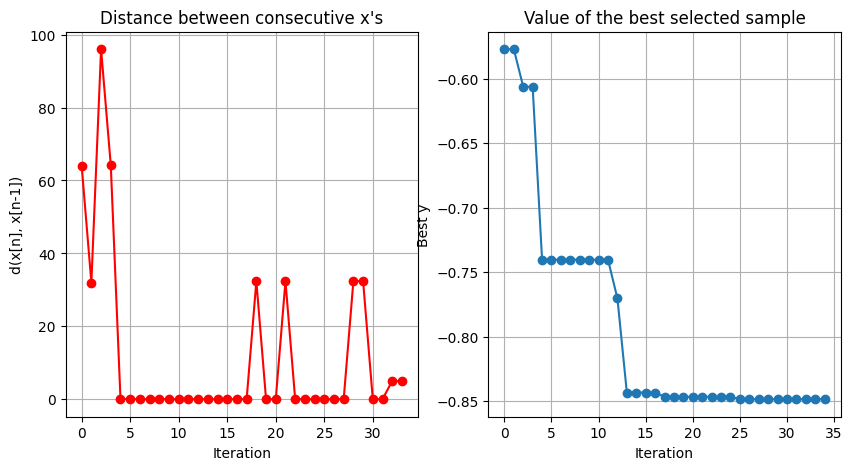

Best Hyperparameters:  
Learning Rate: 1e-06  
Beta1: 0.8933315375778025  
Beta2: 0.9916342361656205  
Number of Epochs: 5  
Batch Size: 64  
